In [1]:
import sys
import numpy as np
np.random.seed(0)

# Main code for Spatial Concrete Dropout

In [2]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Wrapper


class SpatialConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given Conv2D input layer.
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """
    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, data_format=None, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(SpatialConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)
        self.data_format = 'channels_last' if data_format is None else 'channels_first'

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(SpatialConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 4, 'this wrapper only supports Conv2D layers'
        if self.data_format == 'channels_first':
            input_dim = input_shape[1] # we drop only channels
        else:
            input_dim = input_shape[3]
        
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def spatial_concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 2. / 3.

        input_shape = K.shape(x)
        if self.data_format == 'channels_first':
            noise_shape = (input_shape[0], input_shape[1], 1, 1)
        else:
            noise_shape = (input_shape[0], 1, 1, input_shape[3])
        unif_noise = K.random_uniform(shape=noise_shape)
        
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.spatial_concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.spatial_concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using TensorFlow backend.


# Evaluate Concrete Dropout on synthetic data

In [17]:
Ns = [10, 25, 50, 100, 1000, 10000]
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000
nb_features = 128
Q = 7 # input image of dim Q x Q x 1
D = 1
K_test = 20
nb_reps = 3
batch_size = 20
l = 1e-4

In [29]:
def gen_data(N):
    sigma = 1e0  # ground truth
    X = np.ones((N, Q, Q, 1)) / (Q * Q * 1.)
    X[:, 0, 0, 0] = np.random.randn(N) # some stupid data which is easy to plot
    w = 2.
    b = 8.
    Y = w * X[:, 0, 0, 0, None] + b + sigma * np.random.randn(N, D) # we use only the top left pixel for target
    return X, Y

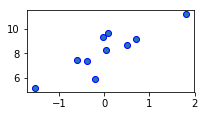

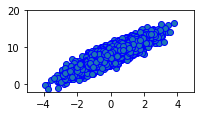

In [30]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0, 0, 0], Y[:, 0], edgecolor='b')
pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0, 0, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

### Fit function:

In [31]:
from keras.layers import Input, Dense, Conv2D, merge, Flatten
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q, Q, 1))
    x = inp
    x = SpatialConcreteDropout(Conv2D(nb_features, 3, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = SpatialConcreteDropout(Conv2D(nb_features, 3, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = SpatialConcreteDropout(Conv2D(nb_features, 3, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = Flatten()(x)
    mean = Dense(D)(x)
    log_var = Dense(D)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 3  # a loss for each Concrete Dropout layer
    hist = model.fit(X, Y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)
    loss = hist.history['loss'][-1]
    return model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [32]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, MC_samples):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    mean = MC_samples[:, :, :D]  # K x N x D
    logvar = MC_samples[:, :, D:]
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_true[None])**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi)
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_true)**2.)**0.5
    return pppp, rmse

### Plot function to make sure stuff makes sense:

In [33]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0, 0, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0, 0, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0, 0, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0, 0, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0, 0, 0], mean[:, 0], c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0, 0, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0, 0, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

# Run experiment

/scratch-ssd/miniconda2/envs/tf/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/scratch-ssd/miniconda2/envs/tf/lib/python2.7/site-packages/ipykernel/__main__.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


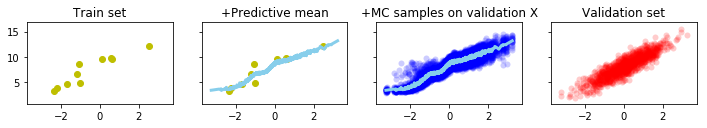

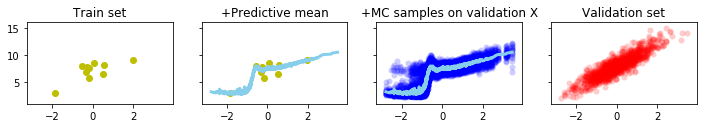

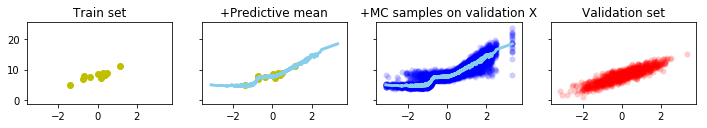

10 2000 - 1.42404123381 0.204564543923 [ 0.05185099  0.40305805  0.39857927]  -  0.876251687825 0.686217173259


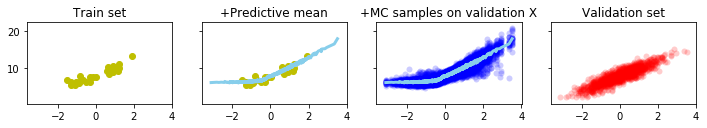

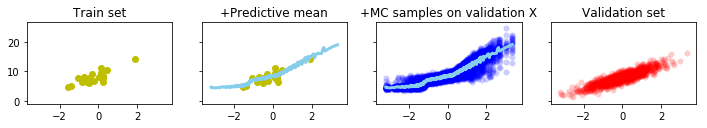

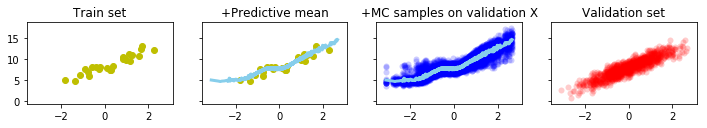

25 1000 - 1.29339597696 0.0741647108958 [ 0.05184698  0.40187147  0.39318356]  -  1.11488515861 0.699253699426


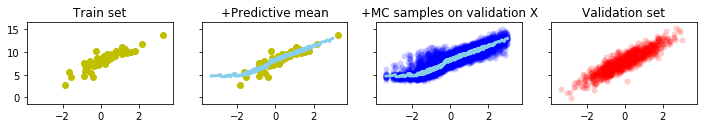

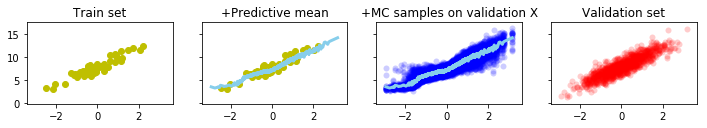

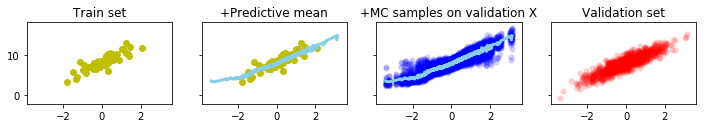

50 500 - 1.08841434812 0.0317100310316 [ 0.05039189  0.31961951  0.31423739]  -  1.16591210601 0.639217202225


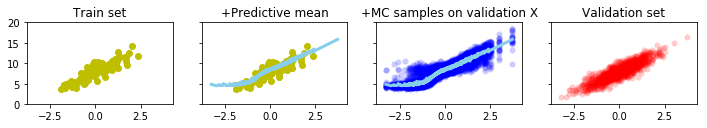

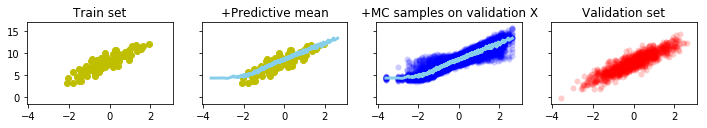

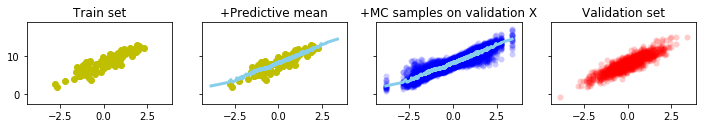

100 200 - 1.10128143403 0.0275797003075 [ 0.05742563  0.22946179  0.22686438]  -  1.20045824639 0.624057416633


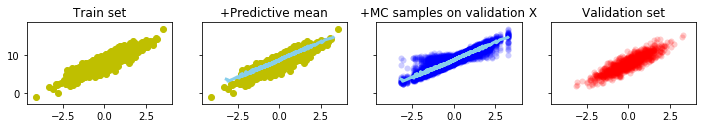

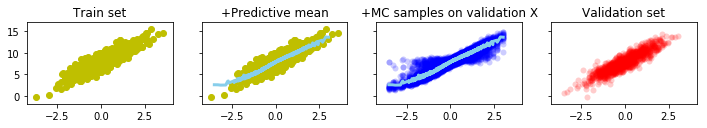

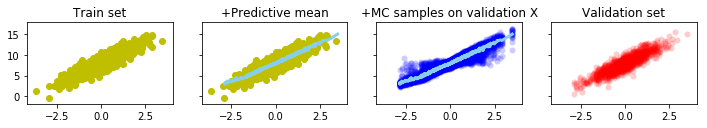

1000 20 - 1.11671795041 0.070574465521 [ 0.05751082  0.1135959   0.10453307]  -  1.10391039243 0.513472979081


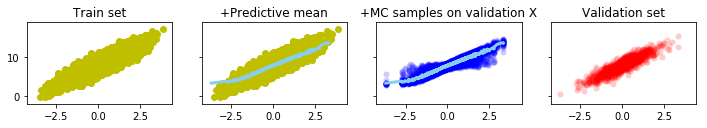

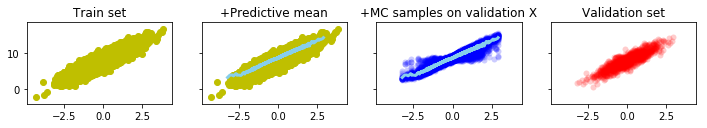

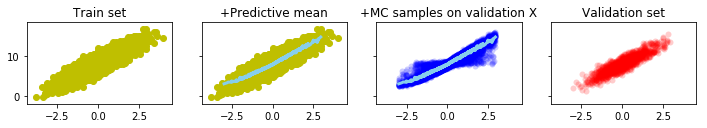

10000 2 - 1.09184851668 0.0778603961275 [ 0.05649133  0.0810608   0.07998722]  -  1.15533679263 0.470780884584


In [34]:
results = []
# get results for multiple N
for N, nb_epoch in zip(Ns, nb_epochs):
    # repeat exp multiple times
    rep_results = []
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model, ELBO = fit_model(nb_epoch, X_train, Y_train)
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        pppp, rmse = test(Y_val, MC_samples)  # per point predictive probability
        means = MC_samples[:, :, :D]  # K x N
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(MC_samples[:, :, D:], 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5
    sys.stdout.flush()
    results += [rep_results]

In [35]:
import pickle
with open('spatial-concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [36]:
# import pickle
# with open('spatial-concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [37]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

[ 1.42404123  1.29339598  1.08841435  1.10128143  1.11671795  1.09184852]
[[ 0.05185099  0.40305805  0.39857927]
 [ 0.05184698  0.40187147  0.39318356]
 [ 0.05039189  0.31961951  0.31423739]
 [ 0.05742563  0.22946179  0.22686438]
 [ 0.05751082  0.1135959   0.10453307]
 [ 0.05649133  0.0810608   0.07998722]]


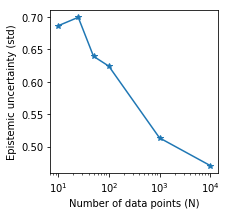

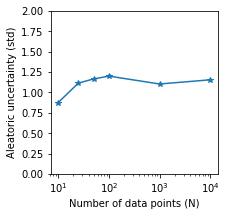

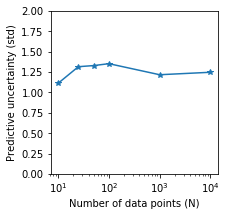

In [38]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('aleatoric.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

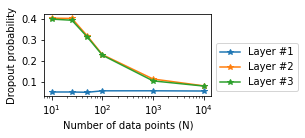

In [39]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()

# MNIST example
### using both Spatial and dense ConcreteDropout

In [46]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

In [55]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

N = len(x_train)
wd = 1e-2 / N
dd = 2. / N
model = Sequential()
model.add(SpatialConcreteDropout(Conv2D(32, kernel_size=(3, 3),
                                        activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd,
                                 input_shape=input_shape))
model.add(SpatialConcreteDropout(Conv2D(64, (3, 3), activation='relu'),
                                 weight_regularizer=wd, dropout_regularizer=dd))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(ConcreteDropout(Dense(128, activation='relu'), 
                          weight_regularizer=wd, dropout_regularizer=dd))
model.add(ConcreteDropout(Dense(num_classes, activation='softmax'), 
                          weight_regularizer=wd, dropout_regularizer=dd))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s - loss: 0.2201 - acc: 0.9117 - val_loss: -0.0013 - val_acc: 0.9671
Epoch 2/20
60000/60000 [==============================] - 5s - loss: -0.0259 - acc: 0.9721 - val_loss: -0.0542 - val_acc: 0.9751
Epoch 3/20
60000/60000 [==============================] - 5s - loss: -0.0862 - acc: 0.9803 - val_loss: -0.1090 - val_acc: 0.9815
Epoch 4/20
60000/60000 [==============================] - 5s - loss: -0.1253 - acc: 0.9839 - val_loss: -0.1309 - val_acc: 0.9815
Epoch 5/20
60000/60000 [==============================] - 5s - loss: -0.1509 - acc: 0.9861 - val_loss: -0.1547 - val_acc: 0.9832
Epoch 6/20
60000/60000 [==============================] - 5s - loss: -0.1660 - acc: 0.9878 - val_loss: -0.1569 - val_acc: 0.9833
Epoch 7/20
60000/60000 [==============================] - 5s - loss: -0.1750 - acc: 0.989

In [56]:
ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
print ps

[ 0.01210067  0.03862968  0.47757214  0.05497763]


In [49]:
# hand-tuned dropout probs in 
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py 
# are:
# 0, 0, 0.25, 0.5
# achieving 0.9898 test accuracy